In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from model import HawkesTransformer
from train import train, run_epoch
from dataset_wrapper import LobDataset, prepare_datasets
from utils import fix_seed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
TRAIN_MODEL = True # set to False if you wish to use weights
WEIGHT_NAME = None # change if you wish to upload existing weights (without pth)
GLOBAL_DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
GLOBAL_SEED = 42
DATA_DIR = "/content/drive/MyDrive/LOB datasets/"

In [4]:
torch.cuda.empty_cache()
!nvidia-smi

Tue Dec 15 16:47:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    47W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
train_dsets, val_dsets, test_dsets = prepare_datasets(DATA_DIR)

In [6]:
dataset_names = list(train_dsets.keys())
train_sets, val_sets = [], []
for name in dataset_names:
    train_sets.append(train_dsets[name].sliced_data)
    val_sets.append(val_dsets[name].sliced_data)
train_dset, val_dset = np.concatenate(train_sets), np.concatenate(val_sets)

In [7]:
fix_seed(GLOBAL_SEED)
model = HawkesTransformer(2, GLOBAL_DEVICE, 512, 4, 1024, 4, 0.1, 'relu').to(GLOBAL_DEVICE)

if TRAIN_MODEL:
    train_dset = LobDataset(train_dset, slice_inputs=False, preprocess=False)
    val_dset = LobDataset(val_dset, slice_inputs=False, preprocess=False)

    train_loader = utils_data.DataLoader(train_dset, batch_size=5, shuffle=True)
    val_loader = utils_data.DataLoader(val_dset, batch_size=5, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-5, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, threshold=0.001, patience=10, verbose=True)
    n_epochs  = 100

    train_history, val_history = train(model, n_epochs, optimizer, train_loader, val_loader, scheduler, GLOBAL_DEVICE, verbose=True, freq=10,\
                                      early_stopping=True, patience=15, checkpoint=True, cp_name='model_all')
else:
    model.load_state_dict(torch.load('{}.pth'.format(WEIGHT_NAME)))

[ Epoch 10 ]
(Training)     log-likelihood: -4.138845156316179, RMSE: 27.032851514031325, CE: 0.6056591060236803, accuracy: 0.7113798627496756
(Validation)   log-likelihood: -4.2808191525981805, RMSE: 29.14372242167532, CE: 0.6151131234395242, accuracy: 0.6991564237887725
Time elapsed: 450.84 s
[ Epoch 20 ]
(Training)     log-likelihood: -4.059884059985176, RMSE: 25.066929621400185, CE: 0.6046544262338558, accuracy: 0.7113578308398437
(Validation)   log-likelihood: -4.24436928405372, RMSE: 27.93486310889907, CE: 0.6137352270997161, accuracy: 0.6991564237887725
Time elapsed: 900.84 s
[ Epoch 30 ]
(Training)     log-likelihood: -4.01952400829892, RMSE: 23.680075290784895, CE: 0.6034380120449537, accuracy: 0.7113709652476281
(Validation)   log-likelihood: -4.212564328404374, RMSE: 27.229297131668588, CE: 0.6154414872917908, accuracy: 0.6990848801452336
Time elapsed: 1351.00 s
[ Epoch 40 ]
(Training)     log-likelihood: -3.9892427607806544, RMSE: 22.368922587121602, CE: 0.6025577911542703,

In [9]:
inference_results = {}
model.eval()
for name in dataset_names:
    test_loader = utils_data.DataLoader(test_dsets[name], batch_size=5, shuffle=False)
    print("INFERENCE ON {}...".format(name))
    test_ll, test_mse, test_ce, test_accuracy = run_epoch(model, test_loader, GLOBAL_DEVICE)
    inference_results[name] = {
        'log-likelihood' : test_ll,
        'RMSE' : np.sqrt(test_mse),
        'cross entropy' : test_ce,
        'accuracy' : test_accuracy
    }
    print("SUCCESSFULLY TESTED ON {}".format(name))

INFERENCE ON EOS...
SUCCESSFULLY TESTED ON EOS
INFERENCE ON LTC...
SUCCESSFULLY TESTED ON LTC
INFERENCE ON ETH...
SUCCESSFULLY TESTED ON ETH
INFERENCE ON BNB...
SUCCESSFULLY TESTED ON BNB
INFERENCE ON XRP...
SUCCESSFULLY TESTED ON XRP


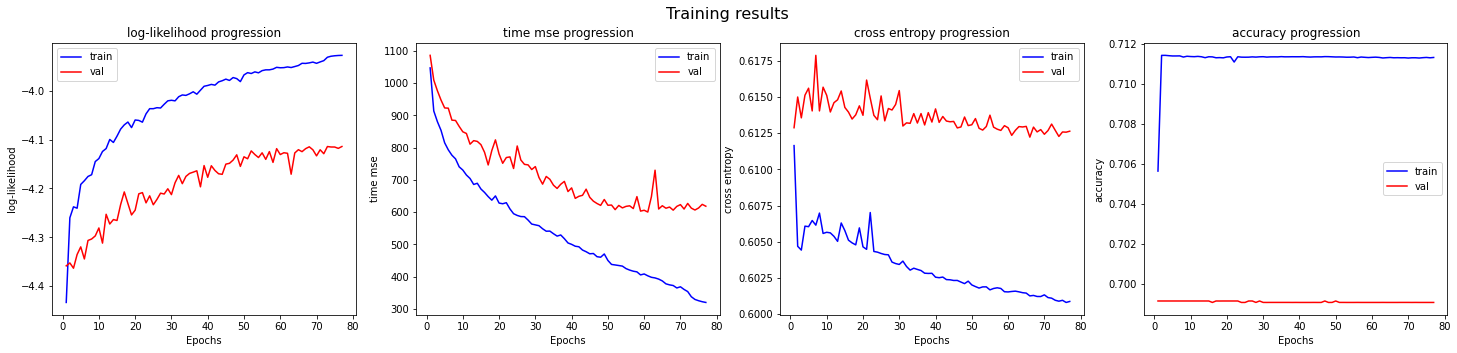

In [12]:
if TRAIN_MODEL:
    metrics = ['log-likelihood', 'time mse', 'cross entropy', 'accuracy']
    epochs = list(range(1, len(train_history['log-likelihood']) + 1))
    fig, axes = plt.subplots(1, 4, figsize=(25,5))
    fig.suptitle('Training results', fontsize=16)
    for ax, metric in zip(axes, metrics):
        ax.plot(epochs, train_history[metric], c='b', label='train')
        ax.plot(epochs, val_history[metric], c='r', label='val')
        ax.set_title('{} progression'.format(metric))
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric)
        ax.legend()
    plt.show()

In [13]:
print("TEST RESULTS:")
print("")

for name in dataset_names:
    print("{} RESULTS:".format(name))
    print("Log-Likelihood:", inference_results[name]['log-likelihood'])
    print("RMSE:", inference_results[name]['RMSE'])
    print("Cross Entropy:", inference_results[name]['cross entropy'])
    print("Accuracy:", inference_results[name]['accuracy'])

TEST RESULTS:

EOS RESULTS:
Log-Likelihood: -4.073921262254902
RMSE: 35.11746807713839
Cross Entropy: 0.605775473717955
Accuracy: 0.7072357452484161
LTC RESULTS:
Log-Likelihood: -4.2665310246394235
RMSE: 25.84380367805849
Cross Entropy: 0.6060220945042578
Accuracy: 0.7067484033139252
ETH RESULTS:
Log-Likelihood: -3.7510466108981917
RMSE: 12.544811966646883
Cross Entropy: 0.6091830061548622
Accuracy: 0.7031620603094113
BNB RESULTS:
Log-Likelihood: -4.941699280753968
RMSE: 50.0563655204416
Cross Entropy: 0.6060888878882247
Accuracy: 0.7068467266866734
XRP RESULTS:
Log-Likelihood: -4.600949455492424
RMSE: 48.595711342170894
Cross Entropy: 0.6073846891119641
Accuracy: 0.7067103175806076
